In [1]:

import os
import sys
module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import data_download
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model
import statsmodels.stats as stats
import statsmodels.stats.api as sms
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.feature_selection import RFE

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
ordtable, cattable = data_download.get_tables(data_download.get_dataframes())

Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
    
Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip
    


/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
    


/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Lookup.zip
    


## Correlation matrix of ordinal features

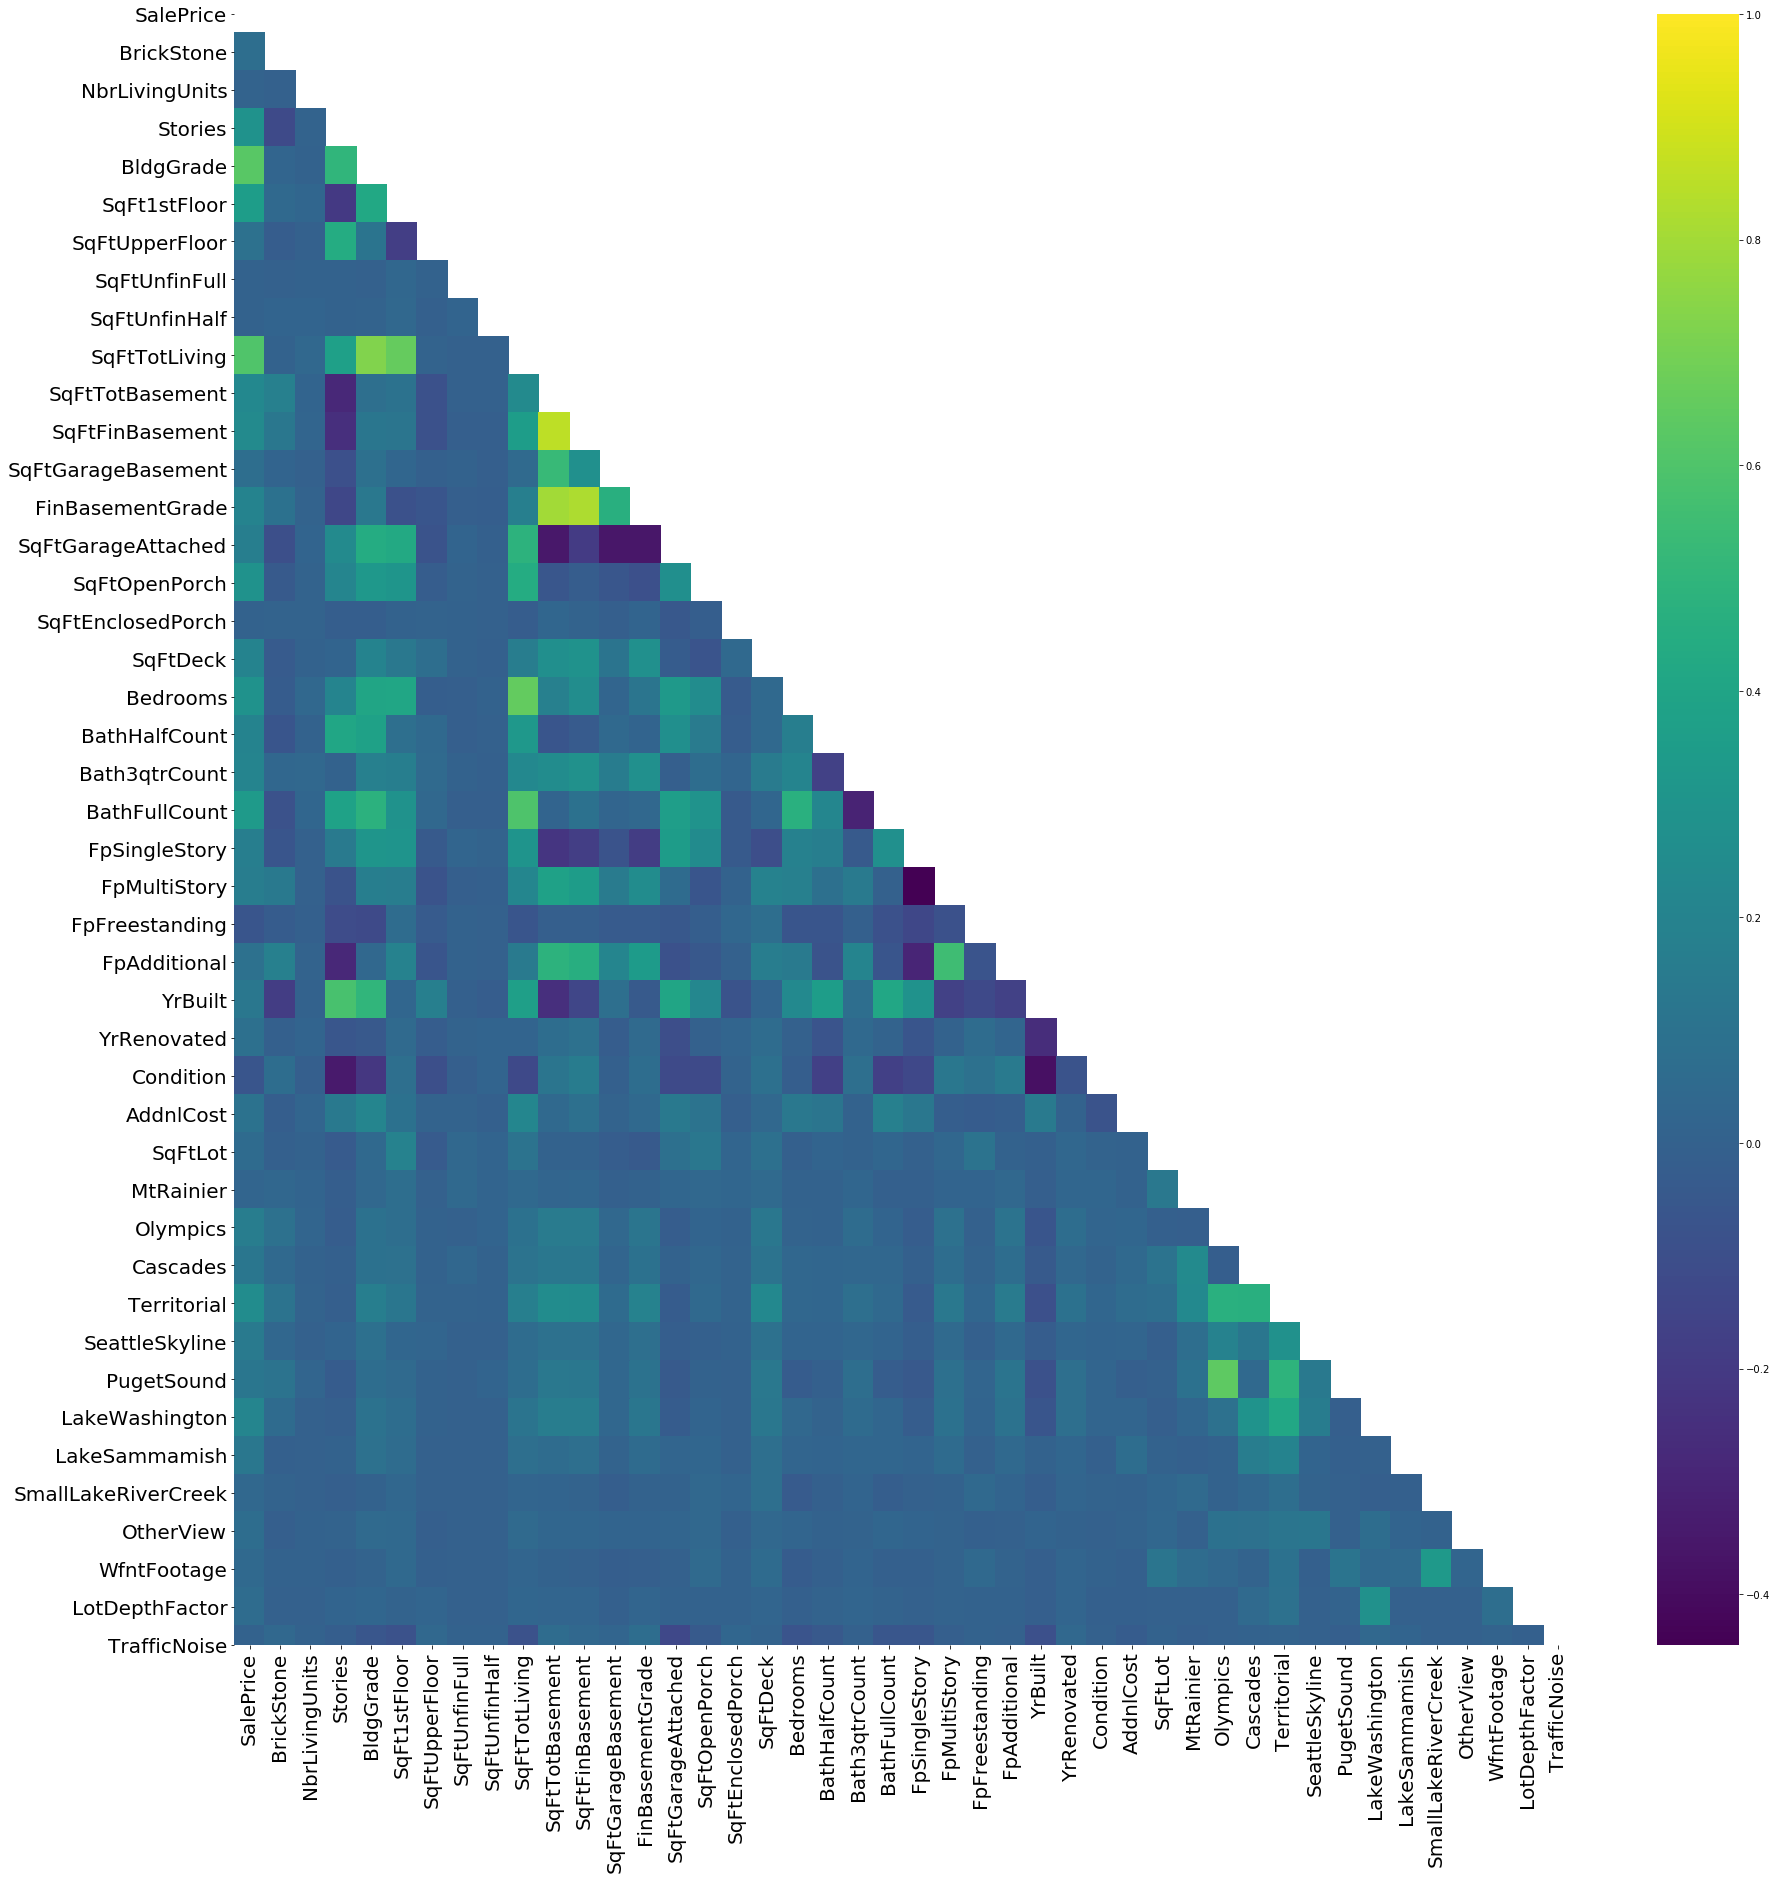

In [3]:
mask = np.triu(np.ones_like(ordtable.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize = (30,30))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.heatmap(ordtable.corr(), mask= mask, ax = ax, cmap = 'viridis')

## Correlation matrix heatmap of 20 highest correlated columns

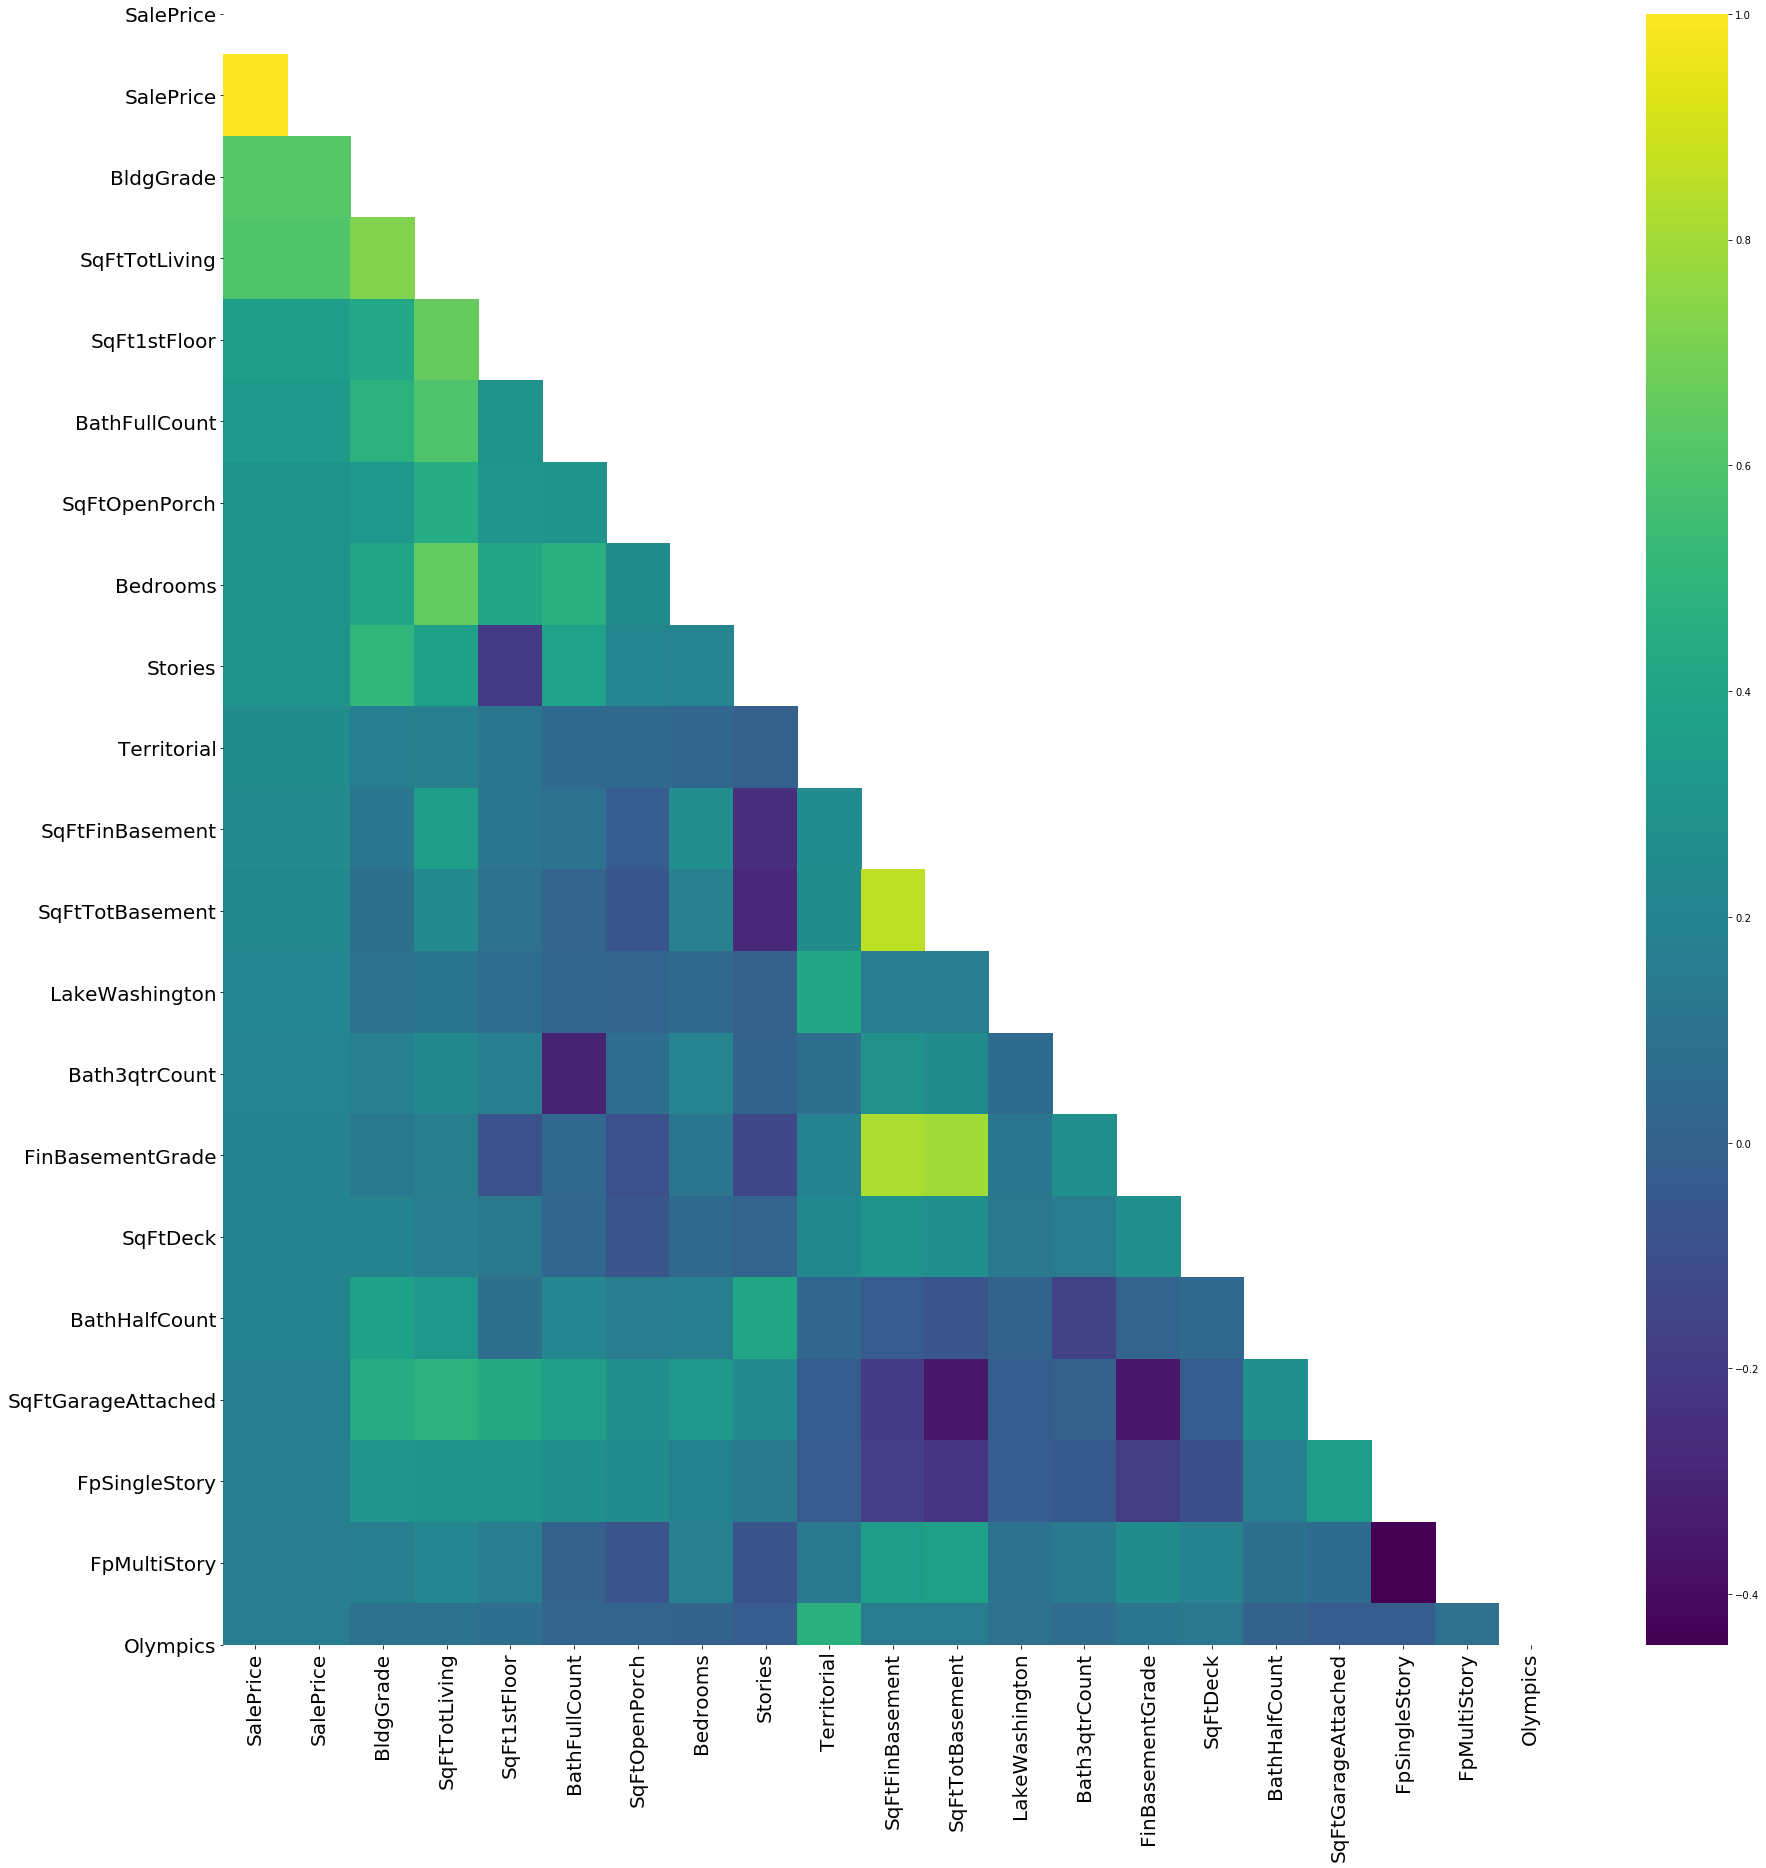

In [4]:
ordcorrs = ordtable.corr()['SalePrice'].abs().sort_values(ascending = False).head(20)
bigcorrs = ordtable[['SalePrice'] + list(ordcorrs.index)]

mask = np.triu(np.ones_like(bigcorrs.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize = (30,30))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.heatmap(bigcorrs.corr(), mask= mask, ax = ax, cmap = 'viridis')

I decided not to limit myself to the highest correlated values to `SalePrice` and instead use recursive feature elimination to choose features for me.



## Standardize and scale the features to better interpret coefficients

In [5]:
# pt = preprocessing.StandardScaler()
# stardardords = pd.DataFrame(pt.fit_transform(ordtable))
# stardardords.columns = ordtable.columns

## Let RFE choose my features for me

In [6]:
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=17)
select = select.fit(X = stardardords.drop('SalePrice', axis=1), y = stardardords['SalePrice'])
predictors = stardardords[stardardords.columns[[True] + list(select.support_) ]]

## Feed the selected predictors into the regression model

In [43]:
preds = 'SalePrice ~ AbvStand8' + str(predictors.columns[1])
for pred in predictors.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = predictors).fit()
model.summary()

PatsyError: Error evaluating factor: NameError: name 'AbvStand8BldgGrade' is not defined
    SalePrice ~ AbvStand8BldgGrade + SqFt1stFloor + SqFtUpperFloor + SqFtTotLiving + SqFtFinBasement + FinBasementGrade + SqFtGarageAttached + SqFtOpenPorch + Bedrooms + Bath3qtrCount + BathFullCount + YrBuilt + AddnlCost + Olympics + SeattleSkyline + LakeWashington + LakeSammamish
                ^^^^^^^^^^^^^^^^^^

## Let's check an assumption or two

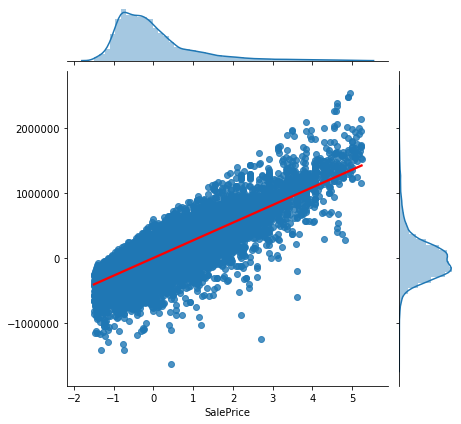

In [37]:
sns.jointplot(predictors['SalePrice'], model.resid, kind = 'reg', line_kws = {'color':"red"});

### The errors look normal


#### but: 
1. We see heteroskadicity. 
2. Our errors are correlated to our target.

# Next steps: 

1. Examine linearity
2. Try to reduce heteroskadacity
3. See what we can do about the correlation of errors to target
4. Try log scaling, or cube scaling on target variables to reduce it's skew.
5. One-hot `BldgGrade`
6. Add other categorical features to improve R<sup>2</sup>



### Map `BldgGrade` to `SalePrice` to see if it's linearly correlated

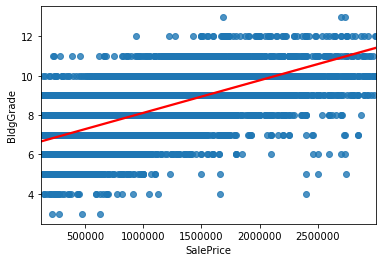

In [9]:
sns.regplot(ordtable.SalePrice, ordtable.BldgGrade, line_kws = {'color':"red"});

`BldgGrade` 9 and 10 are not linearly correlated at all.  In fact, I see weak linear correlation in many categories.

In [10]:
ordtable

,SalePrice,BrickStone,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,FinBasementGrade,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,AddnlCost,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,LotDepthFactor,TrafficNoise
0,193000,0,1,1.0,7,1140,0,0,0,1760,1030,620,410,6,100,0,0,220,3,0,1,1,0,1,0,0,1980,0,3,0,9670,0,0,0,0,0,0,0,0,0,0,0,0,1
1,550000,0,1,3.0,8,370,650,0,0,1560,0,0,0,0,240,0,0,200,2,1,0,1,0,1,0,0,1985,0,3,0,2500,0,0,0,0,0,0,0,0,0,0,0,0,0
2,648500,0,1,2.0,8,1390,0,0,0,3300,0,0,0,0,590,0,0,0,5,1,0,2,1,0,0,0,2005,0,3,6000,5250,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1445000,0,1,2.0,9,2150,0,0,0,4920,0,0,0,0,490,300,0,0,5,2,1,3,1,0,0,0,2018,0,3,0,5499,0,0,0,0,0,0,0,0,0,0,0,0,0
4,785000,0,1,2.0,8,580,0,0,0,1540,560,350,210,8,0,0,0,110,3,1,2,1,1,0,0,0,1998,0,3,0,1313,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28296,669950,0,1,2.0,8,1193,0,0,0,2482,0,0,0,0,800,300,0,0,5,1,0,3,2,0,0,0,2018,0,3,0,11000,0,0,0,0,0,0,0,0,0,0,0,0,2
28297,1150000,0,1,1.5,7,1340,0,0,0,2910,850,850,0,7,0,0,0,140,4,0,1,1,0,1,0,0,1945,0,4,0,8360,0,0,0,0,0,0,0,0,0,0,0,0,0
28298,764500,25,1,1.0,8,1740,0,0,0,2900,1160,1160,0,7,0,230,0,0,4,1,0,1,0,1,0,1,1955,0,4,0,14889,0,0,0,0,0,0,0,0,0,0,0,0,0
28299,469000,0,1,2.0,9,1240,0,0,0,2420,0,0,0,0,510,40,0,0,4,1,0,2,0,1,0,0,1990,0,3,4610,6175,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
from sklearn import preprocessing as ppc

ohe = ppc.OneHotEncoder(sparse = False)

varsdf = pd.DataFrame(ohe.fit_transform(cattable[['PropertyClass']]),  index = cattable.index)
varsdf.columns = ['PropC' + str(pc) for pc in list(ohe.categories_[0])]
varsdf.drop('PropC1.0', axis= 1, inplace = True)
varsdf

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,PropC2.0,PropC3.0,PropC7.0,PropC8.0,PropC9.0
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
28296,0.0,0.0,0.0,1.0,0.0
28297,0.0,0.0,0.0,1.0,0.0
28298,0.0,0.0,0.0,1.0,0.0
28299,0.0,0.0,0.0,1.0,0.0


In [40]:
ordtable['SubStand2'] = varsdf['PropC2.0'].to_numpy()
ordtable['SubStand3'] = varsdf['PropC3.0'].to_numpy()
ordtable['AveStand7'] = varsdf['PropC7.0'].to_numpy()
ordtable['AbvStand8'] = varsdf['PropC8.0'].to_numpy()
ordtable['AbvStand9'] = varsdf['PropC9.0'].to_numpy()

In [41]:
ordtable

,SalePrice,BrickStone,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,FinBasementGrade,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,AddnlCost,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntFootage,LotDepthFactor,TrafficNoise,SubStand2,SubStand3,AveStand7,AbvStand8,AbvStand9
0,193000,0,1,1.0,7,1140,0,0,0,1760,1030,620,410,6,100,0,0,220,3,0,1,1,0,1,0,0,1980,0,3,0,9670,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0
1,550000,0,1,3.0,8,370,650,0,0,1560,0,0,0,0,240,0,0,200,2,1,0,1,0,1,0,0,1985,0,3,0,2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
2,648500,0,1,2.0,8,1390,0,0,0,3300,0,0,0,0,590,0,0,0,5,1,0,2,1,0,0,0,2005,0,3,6000,5250,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
3,1445000,0,1,2.0,9,2150,0,0,0,4920,0,0,0,0,490,300,0,0,5,2,1,3,1,0,0,0,2018,0,3,0,5499,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
4,785000,0,1,2.0,8,580,0,0,0,1540,560,350,210,8,0,0,0,110,3,1,2,1,1,0,0,0,1998,0,3,0,1313,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28296,669950,0,1,2.0,8,1193,0,0,0,2482,0,0,0,0,800,300,0,0,5,1,0,3,2,0,0,0,2018,0,3,0,11000,0,0,0,0,0,0,0,0,0,0,0,0,2,0.0,0.0,0.0,1.0,0.0
28297,1150000,0,1,1.5,7,1340,0,0,0,2910,850,850,0,7,0,0,0,140,4,0,1,1,0,1,0,0,1945,0,4,0,8360,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
28298,764500,25,1,1.0,8,1740,0,0,0,2900,1160,1160,0,7,0,230,0,0,4,1,0,1,0,1,0,1,1955,0,4,0,14889,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
28299,469000,0,1,2.0,9,1240,0,0,0,2420,0,0,0,0,510,40,0,0,4,1,0,2,0,1,0,0,1990,0,3,4610,6175,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0


In [29]:
formula = 'SalePrice ~ SqFtTotLiving + SubStand2 + SubStand3 + AveStand7 + AbvStand8 + AbvStand9'
model = smf.ols(formula = formula, data = ordtable).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     2665.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:49:04   Log-Likelihood:            -3.9535e+05
No. Observations:               27924   AIC:                         7.907e+05
Df Residuals:                   27917   BIC:                         7.908e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8.559e+05   1.21e+05      7.101      0.000     6.2e+05    1.09e+06
SqFtTotLiving   273.5975      2.173    125.923      0.000     269.339     277.856
SubStand2      5.546e+05    1.7e+05      3.254      0.001    2.21e+05    8.89e+05
SubStand3     -5.472e+05   3.62e+05     -1.514      0.130   -1.26e+06    1.61e+05
AveStand7     -7.097e+05   1.21e+05     -5.844      0.000   -9.48e+05   -4.72e+05
AbvStand8     -6.876e+05   1.21e+05     -5.704      0.000   -9.24e+05   -4.51e+05
AbvStand9     -9.236e+05   2.09e+05     -4.425      0.000   -1.33e+06   -5.14e+05
==============================================================================
Omnibus:                     7846.072   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30498.801
Skew:                           1.359   Prob(JB):                         0.00
Kurtosis:                       7.338   Cond. No.                     4.44e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
subset = sm.add_constant(ordtable[
    ['SqFtTotLiving', 'SubStand2', 'SubStand3', 'AveStand7', 'AbvStand8', 'AbvStand9']])
model = sm.OLS(ordtable['SalePrice'], subset).fit()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     2665.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:42:12   Log-Likelihood:            -3.9535e+05
No. Observations:               27924   AIC:                         7.907e+05
Df Residuals:                   27917   BIC:                         7.908e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.559e+05   1.21e+05      7.101      0.000     6.2e+05    1.09e+06
SqFtTotLiving   273.5975      2.173    125.923      0.000     269.339     277.856
SubStand2      5.546e+05    1.7e+05      3.254      0.001    2.21e+05    8.89e+05
SubStand3     -5.472e+05   3.62e+05     -1.514      0.130   -1.26e+06    1.61e+05
AveStand7     -7.097e+05   1.21e+05     -5.844      0.000   -9.48e+05   -4.72e+05
AbvStand8     -6.876e+05   1.21e+05     -5.704      0.000   -9.24e+05   -4.51e+05
AbvStand9     -9.236e+05   2.09e+05     -4.425      0.000   -1.33e+06   -5.14e+05
==============================================================================
Omnibus:                     7846.072   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30498.801
Skew:                           1.359   Prob(JB):                         0.00
Kurtosis:                       7.338   Cond. No.                     4.44e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
subset2 = sm.add_constant(ordtable[
    ['SqFtTotLiving', 'AveStand7']])
model2 = sm.OLS(ordtable['SalePrice'], subset2).fit()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [32]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     7886.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:51:01   Log-Likelihood:            -3.9542e+05
No. Observations:               27924   AIC:                         7.908e+05
Df Residuals:                   27921   BIC:                         7.909e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.698e+05   5136.356     33.060      0.000     1.6e+05     1.8e+05
SqFtTotLiving   273.1839      2.178    125.448      0.000     268.916     277.452
AveStand7     -2.255e+04   1.51e+04     -1.497      0.134   -5.21e+04    6979.529
==============================================================================
Omnibus:                     8000.751   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31655.173
Skew:                           1.381   Prob(JB):                         0.00
Kurtosis:                       7.424   Cond. No.                     1.74e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
ordtable[ordtable['AveStand7']==1].mean()

SalePrice              847417.423954
BrickStone                  1.545627
NbrLivingUnits              1.005703
Stories                     2.026616
BldgGrade                   8.262357
SqFt1stFloor             1175.176806
SqFtUpperFloor             76.539924
SqFtUnfinFull               0.456274
SqFtUnfinHalf               0.000000
SqFtTotLiving            2562.967681
SqFtTotBasement           259.201521
SqFtFinBasement           154.771863
SqFtGarageBasement         55.171103
FinBasementGrade            2.114068
SqFtGarageAttached        345.629278
SqFtOpenPorch             163.813688
SqFtEnclosedPorch           5.494297
SqFtDeck                   90.627376
Bedrooms                    3.682510
BathHalfCount               0.557034
Bath3qtrCount               0.669202
BathFullCount               1.910646
FpSingleStory               0.766160
FpMultiStory                0.043726
FpFreestanding              0.005703
FpAdditional                0.039924
YrBuilt                  2009.011407
Y

In [22]:
ordtable[ordtable['AbvStand8']==1].mean()

SalePrice              759411.993206
BrickStone                  3.161157
NbrLivingUnits              1.002374
Stories                     1.553859
BldgGrade                   7.709245
SqFt1stFloor             1249.862147
SqFtUpperFloor             15.351061
SqFtUnfinFull               0.571648
SqFtUnfinHalf               0.532637
SqFtTotLiving            2160.230266
SqFtTotBasement           460.894912
SqFtFinBasement           291.729371
SqFtGarageBasement         83.875662
FinBasementGrade            2.902838
SqFtGarageAttached        265.287395
SqFtOpenPorch              76.943675
SqFtEnclosedPorch           5.469299
SqFtDeck                  132.503415
Bedrooms                    3.441721
BathHalfCount               0.479965
Bath3qtrCount               0.531322
BathFullCount               1.596377
FpSingleStory               0.634365
FpMultiStory                0.276473
FpFreestanding              0.063630
FpAdditional                0.163751
YrBuilt                  1977.914673
Y

In [23]:
subset3 = sm.add_constant(ordtable[
    ['AveStand7']])
model3 = sm.OLS(ordtable['SalePrice'], subset3).fit()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [34]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     21.69
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           3.21e-06
Time:                        07:51:14   Log-Likelihood:            -4.0166e+05
No. Observations:               27924   AIC:                         8.033e+05
Df Residuals:                   27922   BIC:                         8.033e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.598e+05   2581.145    294.375      0.000    7.55e+05    7.65e+05
AveStand7   8.759e+04   1.88e+04      4.658      0.000    5.07e+04    1.24e+05
==============================================================================
Omnibus:                    10090.037   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37025.342
Skew:                           1.817   Prob(JB):                         0.00
Kurtosis:                       7.314   Cond. No.                         7.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
subset4 = sm.add_constant(ordtable[
    ['SqFtTotLiving', 'AbvStand8']])
model4 = sm.OLS(ordtable['SalePrice'], subset4).fit()

/Users/reuben/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [26]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     7884.
Date:                Thu, 01 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:42:31   Log-Likelihood:            -3.9542e+05
No. Observations:               27924   AIC:                         7.908e+05
Df Residuals:                   27921   BIC:                         7.909e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.754e+05   1.56e+04     11.239      0.000    1.45e+05    2.06e+05
SqFtTotLiving   272.9491      2.177    125.367      0.000     268.682     277.217
AbvStand8     -5658.3499   1.48e+04     -0.383      0.702   -3.46e+04    2.33e+04
==============================================================================
Omnibus:                     7962.557   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31487.938
Skew:                           1.375   Prob(JB):                         0.00
Kurtosis:                       7.416   Cond. No.                     2.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""